In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import helpers as hp
import stationary as st
import plotresults as pr
import deepvar
import var
import lstm
import warnings 
import irf
warnings.filterwarnings('ignore', message='An unsupported index was provided and will be ignored when e.g. forecasting.')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def prepare_df(df):
    df['log_GDP'] = np.log(df['GDP']) 
    df['log_hhd'] = np.log(df['household_debt']) 
    df['log_pd'] = np.log(df['private_debt']) 
    df['log_CPI'] = np.log(df['CPI']) 
    final_df = df.copy()
    final_df['TIME_PERIOD'] = pd.to_datetime(final_df['TIME_PERIOD'])
    final_df = final_df.set_index(["Country", "TIME_PERIOD"])
    final_df = final_df.drop(columns = {"Code", "GDP","household_debt", "private_debt", 'CPI'})
    return final_df

Basic VAR detrend results

In [3]:
def visualize_model_performance(y_test, y_pred):
    plt.figure(figsize=(12, 6))

    plt.plot(y_test, label='True Values', color='skyblue', linestyle='-', linewidth=2)
    plt.plot(y_pred, label='Predicted Values', color='orange', linestyle='--', linewidth=2)

    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Target', fontsize=14)
    plt.title('True vs. Predicted Values Over Time', fontsize=16)
    
    plt.legend(fontsize=12, loc='upper left')

    plt.tight_layout()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()

In [4]:
'''Gets the model, the X scaler and the y scaler in that order and stores it in a dictionary'''
def get_model_and_scaler(df, variables, inputs, param_dict):
    dict = {}
    for variable in variables:
        # Eventually find a way to store fine tuned versions of the parameters in a dictionary and add that here.
        learning_rate = param_dict[variable]['learning_rate']
        epochs = param_dict[variable]['epochs']
        model_lstm, _, _, _, _, scaler_X, scaler_y = lstm.train_lstm_model(df, inputs, [variable], learning_rate, num_epochs=epochs)
        dict[variable] = [model_lstm, scaler_X, scaler_y]
    return dict

In [5]:
warnings.filterwarnings('ignore', message='X does not have valid feature names, but StandardScaler was fitted with feature names')


In [6]:

without_pr_df = pd.read_csv('./Data/WithoutPolicyRate.csv')
pr_df = pd.read_csv('./Data/WithPolicyRate.csv')

# Calculate percent change by country for each variable
pr_df['gdp_pct_change'] = pr_df.groupby('Country')['GDP'].pct_change() * 100
pr_df['private_debt_pct_change'] = pr_df.groupby('Country')['private_debt'].pct_change() * 100
pr_df['household_debt_pct_change'] = pr_df.groupby('Country')['household_debt'].pct_change() * 100
pr_df['cpi_pct_change'] = pr_df.groupby('Country')['CPI'].pct_change() * 100

pr_df['log_gdp'] = np.log(pr_df['GDP'])

# Calculate the difference in log-transformed GDP by country
pr_df['log_gdp_diff'] = pr_df.groupby('Country')['log_gdp'].diff()



LAG = 1

In [7]:
without_pr_df = prepare_df(without_pr_df)
pr_df = prepare_df(pr_df)
without_pr_df = without_pr_df.drop(columns = {"exchange_rate"})

without_pr_df

log_GDP   log_hhd    log_pd   log_CPI
Country  TIME_PERIOD                                         
Colombia 2005-03-31   18.653538  2.437378  3.346565  4.360629
         2005-06-30   18.673758  2.479643  3.322262  4.377560
         2005-09-30   18.673320  2.506097  3.295096  4.383501
         2005-12-31   18.691415  2.560864  3.284738  4.389638
         2006-03-31   18.712670  2.554977  3.278728  4.402592
...                         ...       ...       ...       ...
Belgium  2023-03-31   11.600238  4.087656  4.892602  4.921802
         2023-06-30   11.603648  4.082609  4.875197  4.918581
         2023-09-30   11.606801  4.072440  4.863681  4.929693
         2023-12-31   11.610080  4.072440  4.870607  4.933628
         2024-03-31   11.612734  4.065602  4.858261  4.948529

[4765 rows x 4 columns]

In [8]:
variables_nopr = without_pr_df.columns
final_detrend_nopr = st.detrend_data(without_pr_df, variables_nopr) 
final_detrend_nopr = final_detrend_nopr[final_detrend_nopr.index.get_level_values("TIME_PERIOD")< "2020-03-31"]
countries_to_drop = ['Argentina', 'Türkiye, Rep of',  'Ireland']
final_detrend_nopr= final_detrend_nopr[~final_detrend_nopr.index.get_level_values('Country').isin(countries_to_drop)]

Index(['Colombia', 'Netherlands, The', 'United Kingdom', 'India', 'Israel',
       'Sweden', 'Thailand', 'Australia', 'New Zealand', 'Ireland', 'Germany',
       'Brazil', 'Mexico', 'Greece', 'Norway', 'Austria', 'Italy', 'Argentina',
       'Singapore', 'France', 'Portugal', 'Hungary', 'Spain', 'Canada',
       'Switzerland', 'United States', 'Denmark', 'Indonesia',
       'China, P.R.: Hong Kong', 'Luxembourg', 'Japan', 'Finland',
       'South Africa', 'Chile', 'Czech Rep.', 'Poland, Rep. of',
       'Türkiye, Rep of', 'Korea, Rep. of', 'Belgium'],
      dtype='object', name='Country')


## Get Summary Statistics

In [9]:
final_detrend_nopr.describe()

summary_stats = final_detrend_nopr.describe().transpose()

latex_table = summary_stats.to_latex(float_format="%.5f")

# Print the LaTeX code (you can copy this directly into your LaTeX document)
print(latex_table)


\begin{tabular}{lrrrrrrrr}
\toprule
 & count & mean & std & min & 25% & 50% & 75% & max \\
\midrule
log_GDP & 3844.00000 & 0.00639 & 0.01036 & -0.07151 & 0.00166 & 0.00676 & 0.01147 & 0.08968 \\
log_hhd & 3844.00000 & 0.00670 & 0.02298 & -0.32190 & -0.00345 & 0.00490 & 0.01455 & 0.33647 \\
log_pd & 3844.00000 & 0.00335 & 0.02521 & -0.13544 & -0.00984 & 0.00242 & 0.01512 & 0.16742 \\
log_CPI & 3844.00000 & 0.00758 & 0.01038 & -0.03516 & 0.00171 & 0.00586 & 0.01163 & 0.16602 \\
\bottomrule
\end{tabular}



In [10]:
train_dt_var_nopr, test_dt_var_nopr = hp.time_panel_split_predict(final_detrend_nopr)
excluding_outlier = hp.exclude_country(final_detrend_nopr,"Indonesia")
excluding_outliers = hp.exclude_country(final_detrend_nopr,"India")
eo_train_dt_var, eo_test_dt_var = hp.time_panel_split_predict(excluding_outliers)

all_lstm_data_nopr = lstm.create_lstm_data(final_detrend_nopr, LAG)

lstm_data_subset_nopr = hp.exclude_country(all_lstm_data_nopr, "Norway")

inputs_nopr = lstm.get_lstm_input(final_detrend_nopr, LAG)
lstm_train_nopr, lstm_val_nopr, lstm_test_nopr= lstm.train_val_test_split(all_lstm_data_nopr)



In [11]:
num_unique_countries = len(final_detrend_nopr.index.get_level_values("Country").unique())
print("Countries", num_unique_countries)
print("Number of obsevations", len(final_detrend_nopr))
# all_lstm_data_nopr.index.get_level_values("TIME_PERIOD").unique().sort_values()

Countries 36
Number of obsevations 3844


In [12]:
# all_lstm_data_nopr[all_lstm_data_nopr['private_debt']>10]
# # Ireland 2015 corporate debt restructuring. Should I omit?
# all_lstm_data_nopr[all_lstm_data_nopr['CPI']>10]
# #  Turkey and Argentina

# all_lstm_data_nopr[all_lstm_data_nopr['log_GDP']>0.15]
# # Pandemic bouncebacks
# # Pandemic crash
# all_lstm_data_nopr[all_lstm_data_nopr['log_GDP']<-0.15]

# all_lstm_data_nopr[all_lstm_data_nopr['household_debt']<-4]

# all_lstm_data_nopr[all_lstm_data_nopr['private_debt']<-10]

# recession = all_lstm_data_nopr[all_lstm_data_nopr['log_GDP']< -.01]

# average_household_debt_recession = recession['log_hhd'].mean()
# average_household_debt_recession 
all_lstm_data_nopr

log_GDP   log_hhd    log_pd   log_CPI  log_GDP_lag1  \
Country  TIME_PERIOD                                                         
Colombia 2005-06-30   0.020220  0.042265 -0.024303  0.016931           NaN   
         2005-09-30  -0.000439  0.026454 -0.027167  0.005941      0.020220   
         2005-12-31   0.018095  0.054767 -0.010357  0.006137     -0.000439   
         2006-03-31   0.021254 -0.005887 -0.006010  0.012954      0.018095   
         2006-06-30   0.016457  0.053916  0.024562  0.014501      0.021254   
...                        ...       ...       ...       ...           ...   
Belgium  2018-12-31   0.009724  0.005046  0.005970  0.007474      0.003900   
         2019-03-31   0.002609  0.006689 -0.001324  0.001629      0.009724   
         2019-06-30   0.005386  0.004988 -0.005978  0.003588      0.002609   
         2019-09-30   0.007315  0.000000  0.015207 -0.001133      0.005386   
         2019-12-31   0.005931  0.011542 -0.009229  0.001317      0.007315   

                      log_hhd_lag1  log_pd_lag1  log_CPI_lag1  
Country  TIME_PERIOD                                           
Colombia 2005-06-30            NaN          NaN           NaN  
         2005-09-30       0.042265    -0.024303      0.016931  
         2005-12-31       0.026454    -0.027167      0.005941  
         2006-03-31       0.054767    -0.010357      0.006137  
         2006-06-30      -0.005887    -0.006010      0.012954  
...                            ...          ...           ...  
Belgium  2018-12-31      -0.001685    -0.022369      0.006126  
         2019-03-31       0.005046     0.005970      0.007474  
         2019-06-30       0.006689    -0.001324      0.001629  
         2019-09-30       0.004988    -0.005978      0.003588  
         2019-12-31       0.000000     0.015207     -0.001133  

[3844 rows x 8 columns]

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/50], Train Loss: 0.9368, Val Loss: 0.3216
Epoch [20/50], Train Loss: 0.9471, Val Loss: 0.3189
Epoch [30/50], Train Loss: 0.9096, Val Loss: 0.3211
Epoch [40/50], Train Loss: 0.9183, Val Loss: 0.3212
Epoch [50/50], Train Loss: 0.9327, Val Loss: 0.3178


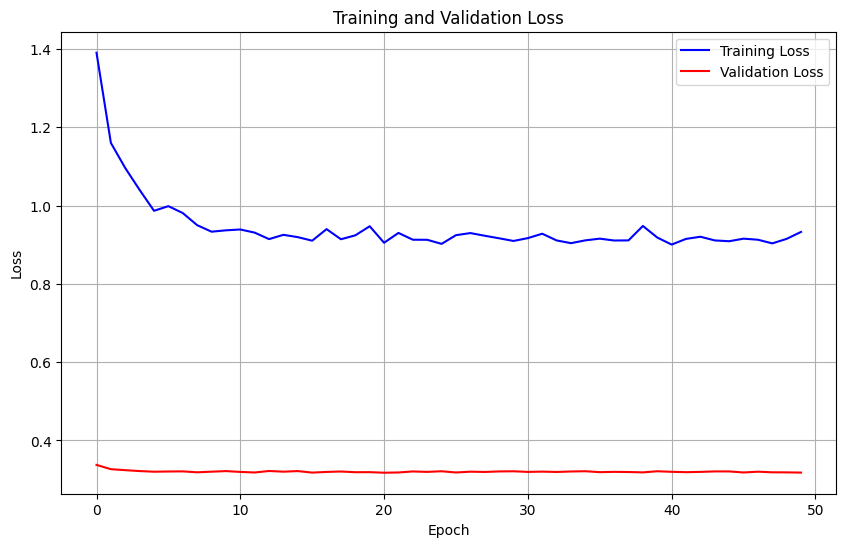

Final LSTM Metrics:
MSE: 4.1076262e-05
RMSE: 0.0064090765
MAE: 0.004485892


In [13]:

GDP_model_lstm_nopr, GDP_predictions_lstm_nopr, GDP_mse_nopr, GDP_rmse_nopr, GDP_mae_nopr, GDP_scaler_X_nopr, GDP_scaler_y_nopr = lstm.train_lstm_model(all_lstm_data_nopr, inputs_nopr, ['log_GDP'], learning_rate = 0.0009, num_epochs= 50)

In [14]:
param_dict = {
    'log_hhd':{'learning_rate': 0.005, 'epochs': 50},
    'log_GDP':{'learning_rate': 0.0009, 'epochs': 50},
    'log_pd': {'learning_rate': .003, 'epochs': 50},
    'log_CPI' : {'learning_rate': .001, 'epochs': 50}
}

gdp_model_lstm_nopr, gdp_predictions_lstm_nopr, gdp_errors, gdp_scaler_X_nopr, gdp_scaler_y_nopr = lstm.train_lstm_model(all_lstm_data_nopr, inputs_nopr, ['log_GDP'], .003, num_epochs= 50)

gdp_var_mse_nopr, gdp_var_rmse_nopr, gdp_var_mae_nopr = var.get_test_errors(final_detrend_nopr, train_dt_var_nopr, test_dt_var_nopr, LAG, 'log_GDP')

eo_gdp_var_mse, eo_gdp_var_rmse, eo_gdp_var_mae = var.get_test_errors(excluding_outliers, train_dt_var_nopr, test_dt_var_nopr, LAG, 'log_GDP')

GDP_lstm_metrics_nopr = [GDP_mse_nopr, GDP_rmse_nopr, GDP_mae_nopr]
GDP_var_metrics_nopr = [gdp_var_mse_nopr, gdp_var_rmse_nopr, gdp_var_mae_nopr]
GDP_no_outlier_var_metrics_nopr = [eo_gdp_var_mse, eo_gdp_var_rmse, eo_gdp_var_mae]




/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:49: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Ho

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/50], Train Loss: 0.8453, Val Loss: 0.1680
Epoch [20/50], Train Loss: 0.8607, Val Loss: 0.1617
Epoch [30/50], Train Loss: 0.8600, Val Loss: 0.1730
Epoch [40/50], Train Loss: 0.8705, Val Loss: 0.1614
Epoch [50/50], Train Loss: 0.8401, Val Loss: 0.1569


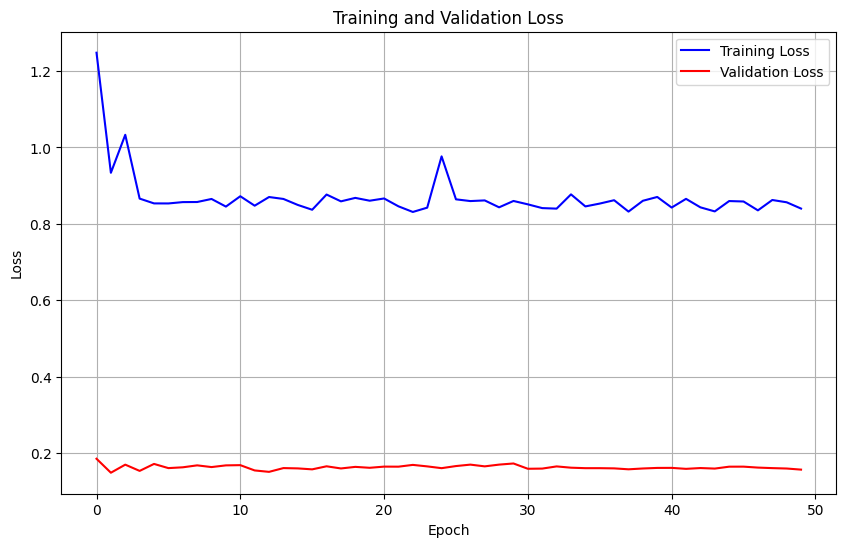

Final LSTM Metrics:
MSE: 0.000102101636
RMSE: 0.010104535
MAE: 0.007146982


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:49: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Ho

In [15]:
hhd_model_lstm_nopr, hhd_predictions_lstm_nopr, hhd_errors, hhd_scaler_X_nopr, hhd_scaler_y_nopr = lstm.train_lstm_model(all_lstm_data_nopr, inputs_nopr, ['log_hhd'], .003, num_epochs= 50)
hhd_var_mse_nopr, hhd_var_rmse_nopr, hhd_var_mae_nopr = var.get_test_errors(final_detrend_nopr, train_dt_var_nopr, test_dt_var_nopr, LAG, 'log_hhd')
eo_hhd_var_mse_nopr, eo_hhd_var_rmse_nopr, eo_hhd_var_mae_nopr = var.get_test_errors(excluding_outliers, train_dt_var_nopr, test_dt_var_nopr, LAG, 'log_hhd')

hhd_lstm_metrics_nopr = [hhd_mse_nopr, hhd_rmse_nopr, hhd_mae_nopr]
hhd_var_metrics_nopr = [hhd_var_mse_nopr, hhd_var_rmse_nopr, hhd_var_mae_nopr]
hhd_no_outlier_var_metrics_nopr = [eo_hhd_var_mse_nopr, eo_hhd_var_rmse_nopr, eo_hhd_var_mae_nopr]

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/50], Train Loss: 0.9369, Val Loss: 0.5465
Epoch [20/50], Train Loss: 0.9365, Val Loss: 0.5421
Epoch [30/50], Train Loss: 0.9189, Val Loss: 0.5503
Epoch [40/50], Train Loss: 0.9249, Val Loss: 0.5469
Epoch [50/50], Train Loss: 0.9461, Val Loss: 0.5514


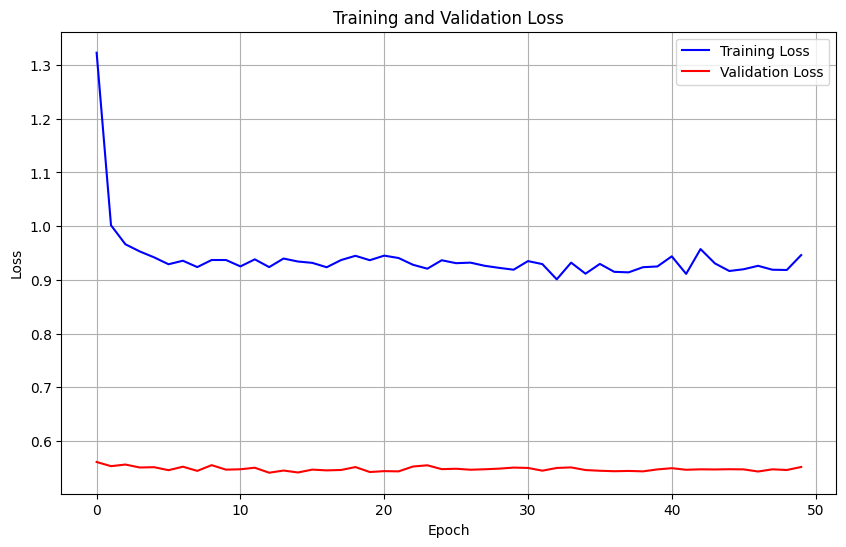

Final LSTM Metrics:
MSE: 0.00038548803
RMSE: 0.01963385
MAE: 0.014207132


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/var.py:49: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_index = pd.date_range(start=time_periods[-len(test)], periods=len(test), freq='Q')
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Ho

In [16]:
fd_model_lstm_nopr, fd_predictions_lstm_nopr, fd_errors, fd_scaler_X_nopr, fd_scaler_y_nopr = lstm.train_lstm_model(all_lstm_data_nopr, inputs_nopr, ['log_pd'], .003, num_epochs= 50)
fd_var_mse_nopr, fd_var_rmse_nopr, fd_var_mae_nopr = var.get_test_errors(final_detrend_nopr, train_dt_var_nopr, test_dt_var_nopr, LAG, 'log_pd')
eo_fd_var_mse_nopr, eo_fd_var_rmse_nopr, eo_fd_var_mae_nopr = var.get_test_errors(excluding_outliers, train_dt_var_nopr, test_dt_var_nopr, LAG, 'log_pd')

fd_lstm_metrics_nopr = [fd_mse_nopr, fd_rmse_nopr, fd_mae_nopr]
fd_var_metrics_nopr = [fd_var_mse_nopr, fd_var_rmse_nopr, fd_var_mae_nopr]
fd_no_outlier_var_metrics_nopr = [eo_fd_var_mse_nopr, eo_fd_var_rmse_nopr, eo_fd_var_mae_nopr]


Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/50], Train Loss: 0.8454, Val Loss: 0.4314
Epoch [20/50], Train Loss: 0.8320, Val Loss: 0.4058
Epoch [30/50], Train Loss: 0.7463, Val Loss: 0.4074
Epoch [40/50], Train Loss: 0.7479, Val Loss: 0.4091
Epoch [50/50], Train Loss: 0.7394, Val Loss: 0.4066


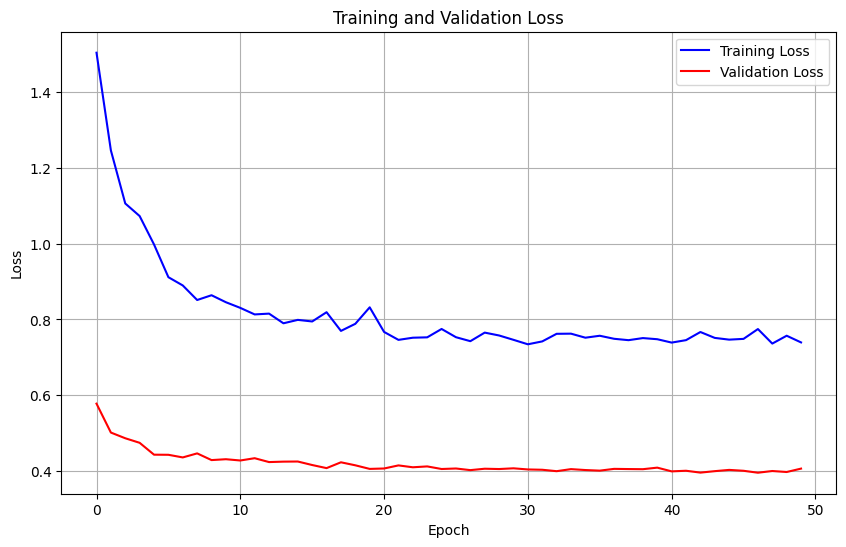

Final LSTM Metrics:
MSE: 4.8907074e-05
RMSE: 0.0069933594
MAE: 0.0053177234


In [17]:
# pr_model_lstm_nopr, pr_predictions_lstm_nopr, pr_mse_nopr, pr_rmse_nopr, pr_mae_nopr, pr_scaler_X_nopr, pr_scaler_y_nopr= train_lstm_model(all_lstm_data_nopr, inputs_nopr, ['policy_rate'], .002, num_epochs= 200)
# er_model_lstm_nopr, er_predictions_lstm_nopr, er_mse_nopr, er_rmse_nopr, er_mae_nopr, er_scaler_X_nopr, er_scaler_y_nopr = train_lstm_model(all_lstm_data_nopr, inputs_nopr, ['exchange_rate'], .002, num_epochs= 200)

cpi_model_lstm_nopr, cpi_predictions_lstm_nopr, cpi_mse_nopr, cpi_rmse_nopr, cpi_mae_nopr, cpi_scaler_X_nopr, cpi_scaler_y_nopr = lstm.train_lstm_model(all_lstm_data_nopr, inputs_nopr, ['log_CPI'], .0005, num_epochs= 50)

In [18]:
all_lstm_data_nopr

log_GDP   log_hhd    log_pd   log_CPI  log_GDP_lag1  \
Country  TIME_PERIOD                                                         
Colombia 2005-06-30   0.020220  0.042265 -0.024303  0.016931           NaN   
         2005-09-30  -0.000439  0.026454 -0.027167  0.005941      0.020220   
         2005-12-31   0.018095  0.054767 -0.010357  0.006137     -0.000439   
         2006-03-31   0.021254 -0.005887 -0.006010  0.012954      0.018095   
         2006-06-30   0.016457  0.053916  0.024562  0.014501      0.021254   
...                        ...       ...       ...       ...           ...   
Belgium  2018-12-31   0.009724  0.005046  0.005970  0.007474      0.003900   
         2019-03-31   0.002609  0.006689 -0.001324  0.001629      0.009724   
         2019-06-30   0.005386  0.004988 -0.005978  0.003588      0.002609   
         2019-09-30   0.007315  0.000000  0.015207 -0.001133      0.005386   
         2019-12-31   0.005931  0.011542 -0.009229  0.001317      0.007315   

                      log_hhd_lag1  log_pd_lag1  log_CPI_lag1  
Country  TIME_PERIOD                                           
Colombia 2005-06-30            NaN          NaN           NaN  
         2005-09-30       0.042265    -0.024303      0.016931  
         2005-12-31       0.026454    -0.027167      0.005941  
         2006-03-31       0.054767    -0.010357      0.006137  
         2006-06-30      -0.005887    -0.006010      0.012954  
...                            ...          ...           ...  
Belgium  2018-12-31      -0.001685    -0.022369      0.006126  
         2019-03-31       0.005046     0.005970      0.007474  
         2019-06-30       0.006689    -0.001324      0.001629  
         2019-09-30       0.004988    -0.005978      0.003588  
         2019-12-31       0.000000     0.015207     -0.001133  

[3844 rows x 8 columns]

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/50], Train Loss: 0.9368, Val Loss: 0.3216
Epoch [20/50], Train Loss: 0.9471, Val Loss: 0.3189
Epoch [30/50], Train Loss: 0.9096, Val Loss: 0.3211
Epoch [40/50], Train Loss: 0.9183, Val Loss: 0.3212
Epoch [50/50], Train Loss: 0.9327, Val Loss: 0.3178


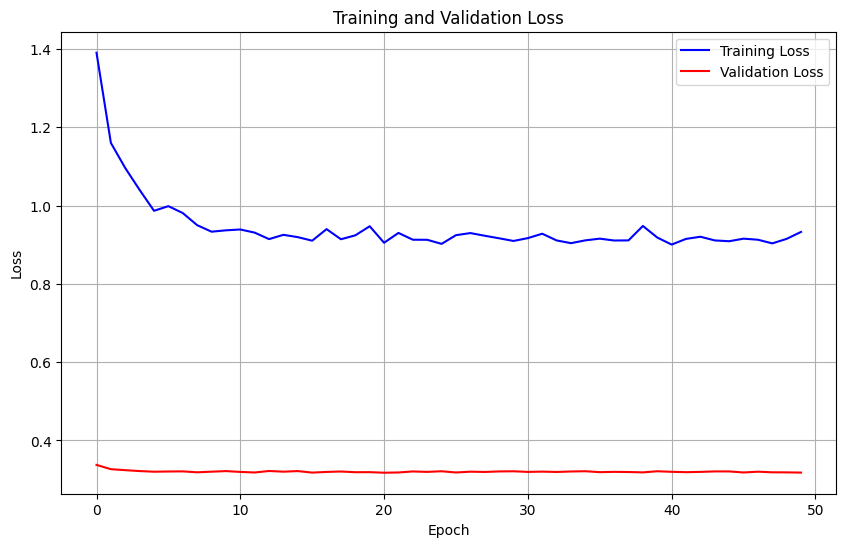

Seed set to 18
Seed set to 18


Final LSTM Metrics:
MSE: 4.1076262e-05
RMSE: 0.0064090765
MAE: 0.004485892


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/50], Train Loss: 0.8500, Val Loss: 0.1696
Epoch [20/50], Train Loss: 0.8615, Val Loss: 0.1624
Epoch [30/50], Train Loss: 0.8528, Val Loss: 0.1706
Epoch [40/50], Train Loss: 0.8646, Val Loss: 0.1612
Epoch [50/50], Train Loss: 0.8399, Val Loss: 0.1546


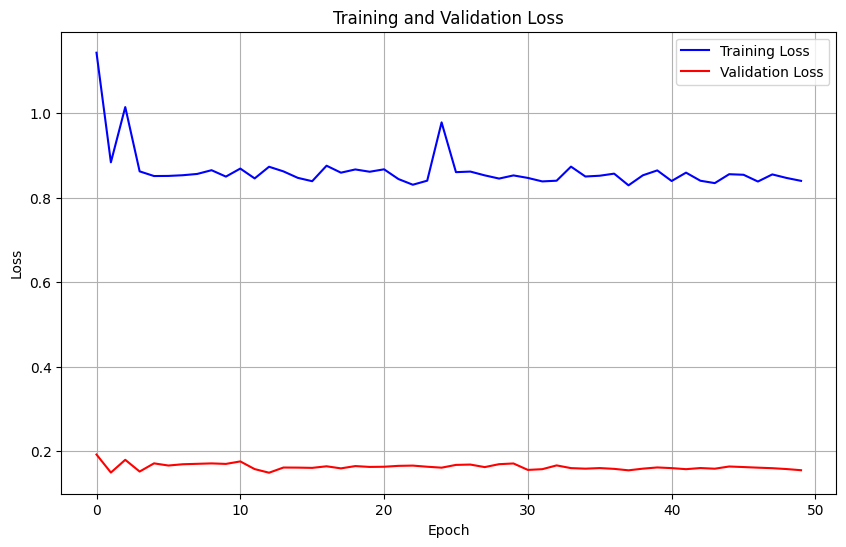

Seed set to 18
Seed set to 18


Final LSTM Metrics:
MSE: 0.00010061648
RMSE: 0.010030777
MAE: 0.0070357346


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/50], Train Loss: 0.9369, Val Loss: 0.5465
Epoch [20/50], Train Loss: 0.9365, Val Loss: 0.5421
Epoch [30/50], Train Loss: 0.9189, Val Loss: 0.5503
Epoch [40/50], Train Loss: 0.9249, Val Loss: 0.5469
Epoch [50/50], Train Loss: 0.9461, Val Loss: 0.5514


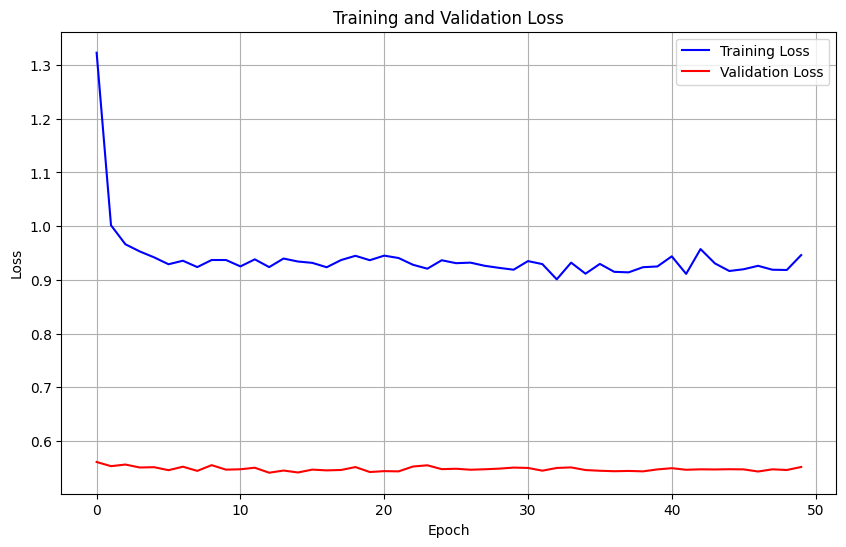

Seed set to 18
Seed set to 18


Final LSTM Metrics:
MSE: 0.00038548803
RMSE: 0.01963385
MAE: 0.014207132


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/50], Train Loss: 0.7719, Val Loss: 0.4130
Epoch [20/50], Train Loss: 0.8122, Val Loss: 0.3942
Epoch [30/50], Train Loss: 0.7317, Val Loss: 0.4037
Epoch [40/50], Train Loss: 0.7388, Val Loss: 0.4043
Epoch [50/50], Train Loss: 0.7308, Val Loss: 0.4023


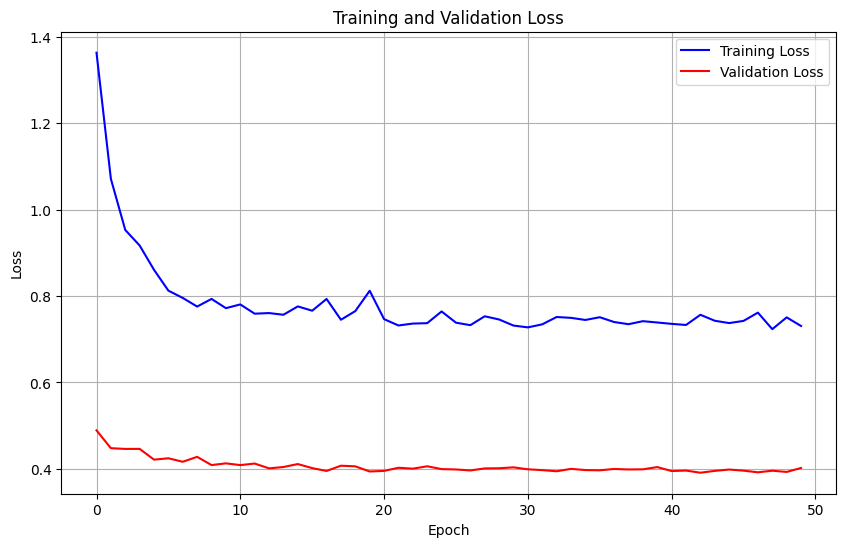

Final LSTM Metrics:
MSE: 4.8397884e-05
RMSE: 0.0069568586
MAE: 0.0052763093


In [19]:
variables = final_detrend_nopr.columns
model_scaler_dict = get_model_and_scaler(all_lstm_data_nopr, variables, inputs_nopr, param_dict)

In [24]:
inputsvar = final_detrend_nopr.columns
gdp_deepvar_metrics_nopr = deepvar.test_errors(all_lstm_data_nopr, lstm_test_nopr, 'log_GDP', model_scaler_dict, inputsvar)
hhd_deepvar_metrics_nopr = deepvar.test_errors(all_lstm_data_nopr, lstm_test_nopr, 'log_hhd', model_scaler_dict, inputsvar)
fd_deepvar_metrics_nopr = deepvar.test_errors(all_lstm_data_nopr, lstm_test_nopr, 'log_pd', model_scaler_dict, inputsvar)

Seed set to 18
Seed set to 18


KeyError: 'log_GDP_lag2'

In [ ]:
gdp_latex_comparison_table_nopr = hp.create_model_comparison_latex_table(gdp_deepvar_metrics_nopr , GDP_var_metrics_nopr, GDP_no_outlier_var_metrics_nopr)
print(gdp_latex_comparison_table_nopr)

hhd_latex_comparison_table_nopr = hp.create_model_comparison_latex_table(hhd_deepvar_metrics_nopr, hhd_var_metrics_nopr, hhd_no_outlier_var_metrics_nopr)
print(hhd_latex_comparison_table_nopr)

fd_latex_comparison_table_nopr = hp.create_model_comparison_latex_table(fd_deepvar_metrics_nopr, fd_var_metrics_nopr, fd_no_outlier_var_metrics_nopr)
print(fd_latex_comparison_table_nopr)


In [ ]:
def calculate_percent_improvement(deepvar_metrics, compare_metrics):
    improvements = {}
    
    # Define the metric names for clarity (order should match the input lists)
    metric_names = ['total_mse', 'rmse', 'total_mae']
    
    for i, metric in enumerate(metric_names):
        # Get the values for DeepVAR and the comparison model
        deepvar_value = deepvar_metrics[i]
        compare_value = compare_metrics[i]
        
        if compare_value != 0:  
            improvement = ((compare_value - deepvar_value) / compare_value) * 100
            improvements[metric] = improvement
        else:
            improvements[metric] = None  
    
    return improvements

improvement_deepvar_vs_var_gdp = calculate_percent_improvement(gdp_deepvar_metrics_nopr, GDP_var_metrics_nopr)
print("GDP model improvement",improvement_deepvar_vs_var_gdp)


improvement_deepvar_vs_var_hhd = calculate_percent_improvement(hhd_deepvar_metrics_nopr, hhd_var_metrics_nopr)
print("household debt model improvement",improvement_deepvar_vs_var_hhd)

improvement_deepvar_vs_var_pd = calculate_percent_improvement(fd_deepvar_metrics_nopr, fd_var_metrics_nopr)
print("private debt model improvement",improvement_deepvar_vs_var_pd)

In [ ]:
plot_data_nopr = lstm_test_nopr.reset_index().drop(columns = {"Country","TIME_PERIOD"})
plot_data_nopr = plot_data_nopr['log_GDP']

visualize_model_performance(plot_data_nopr, GDP_predictions_lstm_nopr)

# GDP_predictions_lstm_df = pd.DataFrame(GDP_predictions_lstm_nopr, columns=["log_GDP"])
# GDP_predictions_lstm_df = GDP_predictions_lstm_df.set_index(lstm_test_nopr.index)

# GDP_predictions_lstm_nopr
lstm_test_nopr


In [ ]:
lstm_test_data = hp.get_test_data(all_lstm_data_nopr)

deepvar.test_errors(all_lstm_data_nopr, lstm_test_nopr, 'log_GDP', model_scaler_dict)


In [ ]:
all_lstm_data_nopr.index.get_level_values("Country").unique()

In [ ]:
countries = ['Colombia', 'Netherlands, The', 'United Kingdom', 'India', 'Israel',
       'Sweden', 'Thailand', 'Australia', 'New Zealand', 'Germany', 'Brazil',
       'Mexico', 'Greece', 'Norway', 'Austria', 'Italy', 'Singapore', 'France',
       'Portugal', 'Hungary', 'Spain', 'Canada', 'Switzerland',
       'United States', 'Denmark', 'Indonesia', 'China, P.R.: Hong Kong',
       'Luxembourg', 'Japan', 'Finland', 'South Africa', 'Chile', 'Czech Rep.',
       'Poland, Rep. of', 'Korea, Rep. of', 'Belgium']

inputsvar = final_detrend_nopr.columns

for country in countries:
       # pr.plot_country_comparison(country, 'log_GDP', inputs_nopr, inputsvar, LAG, final_detrend_nopr, all_lstm_data_nopr, model_scaler_dict)
       pr.plot_country_predictions_test(country, 'log_GDP', inputs_nopr, LAG, all_lstm_data_nopr, model_scaler_dict, train_dt_var_nopr, test_dt_var_nopr, final_detrend_nopr)

## Appendix


In [ ]:
# Test to ensure that detrending is 
# plt.figure(figsize = (12,9))
# plt.plot(df[df['Country']=='Colombia'].index, test1['Household debt'], label = 'Test')
# plt.plot(df[df['Country']=='Colombia'].index, df[df['Country']=='Colombia']['Household debt'], label = 'Real', color = 'orange')
# plt.plot(df_detrended[df_detrended['Country']=='Norway'].index, df_detrended[df_detrended['Country']=='Norway']['log_GDP'], label = 'Real', color = 'skyblue')

In [ ]:
# Testing the model on other data. 

# Look into how it is determining the outcomes. Look at techniques. What part of the data is it looking at. 

In [ ]:
final_detrend_nopr.describe()

summary_stats = final_detrend_nopr.describe().transpose()

latex_table = summary_stats.to_latex(float_format="%.5f")
print(latex_table)

In [ ]:
df_zeros = pd.DataFrame(np.zeros((1, 12)), columns=['log_pd_lag1','log_hhd_lag1', 'log_CPI_lag1', 'log_GDP_lag1'])


Small Change in Household debt % change effect on GDP

In [ ]:
plot1_irf_results = irf.predict(df_zeros, inputs_nopr, 'log_hhd_lag1', .0016, 'log_GDP', 10, model_scaler_dict)
plot1_title = 'Δ% GDP Impulse Response Function (Shock: Increase in Household Debt of .1%)'
plot1_var = '%Δ GDP'
irf.plot(plot1_irf_results, 'log_hhd', plot1_title, plot1_var)

Average Change in Household debt % change effect on GDP

In [ ]:
plot2_irf_results = irf.predict(df_zeros, inputs_nopr, 'log_hhd_lag1', .00676, 'log_GDP', 10, model_scaler_dict)
plot2_title = '%Δ GDP Impulse Response Function (Shock: Increase in Household Debt of .6%)'
plot2_var = '%Δ GDP'
irf.plot(plot2_irf_results, 'log_hhd', plot2_title, plot2_var)

Large Change in Household debt % change effect on GDP

In [ ]:
plot3_irf_results = irf.predict(df_zeros, inputs_nopr, 'log_hhd_lag1', .0115, 'log_GDP', 10, model_scaler_dict)
plot3_title = '%Δ GDP Impulse Response Function (Shock: Increase in Household Debt of 1.15%)'
plot3_var = '%Δ GDP'


irf.plot(plot3_irf_results, 'log_hhd', plot3_title, plot3_var)

In [ ]:
plot4_irf_results = irf.predict(df_zeros, inputs_nopr, 'log_hhd_lag1', -.00615, 'log_GDP', 10, model_scaler_dict)
plot4_title = '%Δ GDP Impulse Response Function (Shock: Decrease in Household Debt of 1%)'
plot4_var = '%Δ GDP'


irf.plot(plot4_irf_results, 'log_hhd', plot4_title, plot4_var)

In [ ]:
plot5_irf_results = irf.predict(df_zeros, inputs_nopr, 'log_hhd_lag1', .00615, 'log_hhd', 10, model_scaler_dict)
plot5_title = '%Δ Household Debt Impulse Response Function (Shock: Increase in Household Debt of .615%)'
plot5_var = '%Δ Household Debt'


irf.plot(plot5_irf_results, 'log_hhd', plot5_title, plot5_var)

In [ ]:
plot6_irf_results = irf.predict(df_zeros, inputs_nopr, 'log_hhd_lag1', .0115, 'log_hhd', 10, model_scaler_dict)
plot6_title = '%Δ Household Debt Impulse Response Function (Shock: Increase in Household Debt of 1.15%)'
plot6_var = '%Δ Household Debt'


irf.plot(plot6_irf_results, 'log_hhd', plot6_title, plot6_var)

In [ ]:
plot6_irf_results = irf.predict(df_zeros, inputs_nopr, 'log_hhd_lag1', -.005, 'log_hhd', 10, model_scaler_dict)
plot6_title = '%Δ Household Debt Impulse Response Function (Shock: Decrease in Household Debt of -0.5%)'
plot6_var = '%Δ Household Debt'


irf.plot(plot6_irf_results, 'log_hhd', plot6_title, plot6_var)

In [ ]:
onesteppredictions = []
twosteppredictions = []
threesteppredictions = []
foursteppredictions = []
fivesteppredictions = []
sixsteppredictions = []
sevensteppredictions = []
eightsteppredictions = []
ninesteppredictions = []
tensteppredictions = []
index = []
for num in np.arange(-.3,.3, 0.001):
    prediction = irf.predict(df_zeros, inputs_nopr, 'log_hhd_lag1', num, 'log_GDP', 10, model_scaler_dict)
    # irf begins at 0 
    onesteppredictions.append(prediction[1])
    twosteppredictions.append(prediction[2])
    threesteppredictions.append(prediction[3])
    foursteppredictions.append(prediction[4])
    fivesteppredictions.append(prediction[5])
    sixsteppredictions.append(prediction[6])
    sevensteppredictions.append(prediction[7])
    eightsteppredictions.append(prediction[8])
    ninesteppredictions.append(prediction[9])
    tensteppredictions.append(prediction[10])
    index.append(num)



fig, axs = plt.subplots(5, 2, figsize=(15, 25))  # 5x2 grid of subplots
axs = axs.ravel()  # Flatten the 2D array of axes for easier indexing

predictions_list = [onesteppredictions, twosteppredictions, threesteppredictions, 
                   foursteppredictions, fivesteppredictions, sixsteppredictions,
                   sevensteppredictions, eightsteppredictions, ninesteppredictions,
                   tensteppredictions]

for i in range(10):
    axs[i].plot(index, predictions_list[i])
    axs[i].set_xlabel("%Δ Household Debt")
    axs[i].set_ylabel(f"%Δ GDP in Time Period {i+1}")
    axs[i].set_title(f"DeepVAR Prediction of Household Debt Changes on GDP Growth in Quarter {i+1}")

plt.tight_layout() 
plt.show()

In [ ]:
onesteppredictions = []
twosteppredictions = []
threesteppredictions = []
foursteppredictions = []
fivesteppredictions = []
sixsteppredictions = []
sevensteppredictions = []
eightsteppredictions = []
ninesteppredictions = []
tensteppredictions = []
index = []
for num in np.arange(-.1,.1, 0.0001):
    prediction = irf.predict(df_zeros, inputs_nopr, 'log_hhd_lag1', num, 'log_hhd', 10, model_scaler_dict)
    # irf begins at 0 
    onesteppredictions.append(prediction[1])
    twosteppredictions.append(prediction[2])
    threesteppredictions.append(prediction[3])
    foursteppredictions.append(prediction[4])
    fivesteppredictions.append(prediction[5])
    sixsteppredictions.append(prediction[6])
    sevensteppredictions.append(prediction[7])
    eightsteppredictions.append(prediction[8])
    ninesteppredictions.append(prediction[9])
    tensteppredictions.append(prediction[10])
    index.append(num)



fig, axs = plt.subplots(5, 2, figsize=(15, 25))  # 5x2 grid of subplots
axs = axs.ravel()  # Flatten the 2D array of axes for easier indexing

predictions_list = [onesteppredictions, twosteppredictions, threesteppredictions, 
                   foursteppredictions, fivesteppredictions, sixsteppredictions,
                   sevensteppredictions, eightsteppredictions, ninesteppredictions,
                   tensteppredictions]

for i in range(10):
    axs[i].plot(index, predictions_list[i])
    axs[i].set_xlabel("%Δ Household Debt")
    axs[i].set_ylabel(f"%Δ Household Debt in Time Period {i+1}")
    axs[i].set_title(f"DeepVAR Prediction of Household Debt Changes on Household Debt in Quarter {i+1}")

plt.tight_layout() 
plt.show()

In [ ]:
onesteppredictions = []
twosteppredictions = []
threesteppredictions = []
foursteppredictions = []
fivesteppredictions = []
sixsteppredictions = []
sevensteppredictions = []
eightsteppredictions = []
ninesteppredictions = []
tensteppredictions = []
index = []
for num in np.arange(-.05,.05, 0.001):
    prediction = irf.predict(df_zeros, inputs_nopr, 'log_hhd_lag1', num, 'log_CPI', 10, model_scaler_dict)
    # irf begins at 0 
    onesteppredictions.append(prediction[1])
    twosteppredictions.append(prediction[2])
    threesteppredictions.append(prediction[3])
    foursteppredictions.append(prediction[4])
    fivesteppredictions.append(prediction[5])
    sixsteppredictions.append(prediction[6])
    sevensteppredictions.append(prediction[7])
    eightsteppredictions.append(prediction[8])
    ninesteppredictions.append(prediction[9])
    tensteppredictions.append(prediction[10])
    index.append(num)



fig, axs = plt.subplots(5, 2, figsize=(15, 25))  # 5x2 grid of subplots
axs = axs.ravel()  # Flatten the 2D array of axes for easier indexing

predictions_list = [onesteppredictions, twosteppredictions, threesteppredictions, 
                   foursteppredictions, fivesteppredictions, sixsteppredictions,
                   sevensteppredictions, eightsteppredictions, ninesteppredictions,
                   tensteppredictions]

for i in range(10):
    axs[i].plot(index, predictions_list[i])
    axs[i].set_xlabel("%Δ Household Debt")
    axs[i].set_ylabel(f"%Δ CPI in Time Period {i+1}")
    axs[i].set_title(f"DeepVAR Prediction of Household Debt Changes on CPI in Quarter {i+1}")

plt.tight_layout() 
plt.show()